# Emotion Classification in Texts using Scikit-learn 

Classifying short messages into five emotion categories. We will prepare our dataset (nltk and regular expressions) and vectorize words using TF-IDF (term frequency-inverse document frequency) metric. Later we will use classifiers provided by scikit-learn and classify sentences into five emotion categories: joy, sadness, anger, fear, and neutral.

### Workflow 
* Importing Dataset
* Text Preprocessing
* Text Representation
* Classifiers: Naive Bayes, Linear Regression, Random Rorrrest, SVM
* Evaluation: F1 scores and Confussion Matrix
* Saving the Model


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

## 1. Import Dataset

Text-Emotion Dataset was split into training 70% and testing 30%


In [2]:
df_train = pd.read_csv('data\data_test.csv', encoding='utf-8')
df_test = pd.read_csv('data\data_test.csv', encoding='utf-8')


X_train = df_train.Text
X_test = df_test.Text

y_train = df_train.Emotion
y_test = df_test.Emotion

class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']
data = pd.concat([df_train, df_test])

print('size of training set: %s' % (len(df_train['Text'])))
print('size of validation set: %s' % (len(df_test['Text'])))
print(data.Emotion.value_counts())

data.head()

size of training set: 3393
size of validation set: 3393
Emotion
joy        1414
anger      1386
fear       1358
sadness    1352
neutral    1276
Name: count, dtype: int64


,Emotion,Text
0,sadness,I experienced this emotion when my grandfather...
1,neutral,"when I first moved in , I walked everywhere ...."
2,anger,"` Oh ! "" she bleated , her voice high and rath..."
3,fear,"However , does the right hon. Gentleman recogn..."
4,sadness,My boyfriend didn't turn up after promising th...


### *Plotting confusion matrix for later evaluation 

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## 2. Text Preprocessing

Here are some preprocessing steps to consider:
* Removing noise: html markups, urls, non-ascii symbols, trailing whitespace etc.
* Removing punctuation
* Normalizing emoticons
* Negation handling
* Tokenization: split text into word tokens
* Stopword removal
* Stemming or lemmatization

However, most of these steps did not improve our classification results. Since our data was mostly taken from written dialogs it was almost ready to use.

In [4]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return str(stem_data)

## 3. Text Representation

Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))
* Tekenize with our preprocess_and_tokenize
* Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
* IDF = log(# of documents / # of documents containing the word)

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [6]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.Text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 4. Classifiers

###  Naive Bayes

Accuracy: 58.38%

F1 Score: 58.38

COnfusion Matrix:
 [[383  79  80  50 101]
 [109 376  94  18  82]
 [ 70  74 406  84  73]
 [ 54  40  60 439  45]
 [ 98  71  93  37 377]]


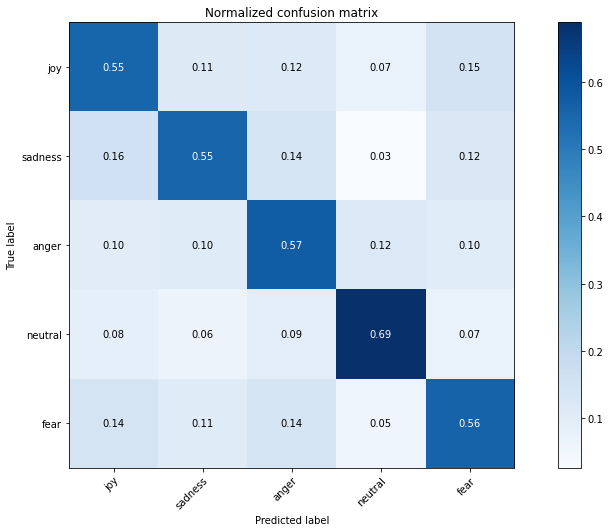

In [9]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Random Forrest

Accuracy: 99.47%

F1 Score: 99.47

COnfusion Matrix:
 [[692   0   0   1   0]
 [  0 679   0   0   0]
 [  0   0 695  12   0]
 [  0   0   0 637   1]
 [  1   0   0   3 672]]


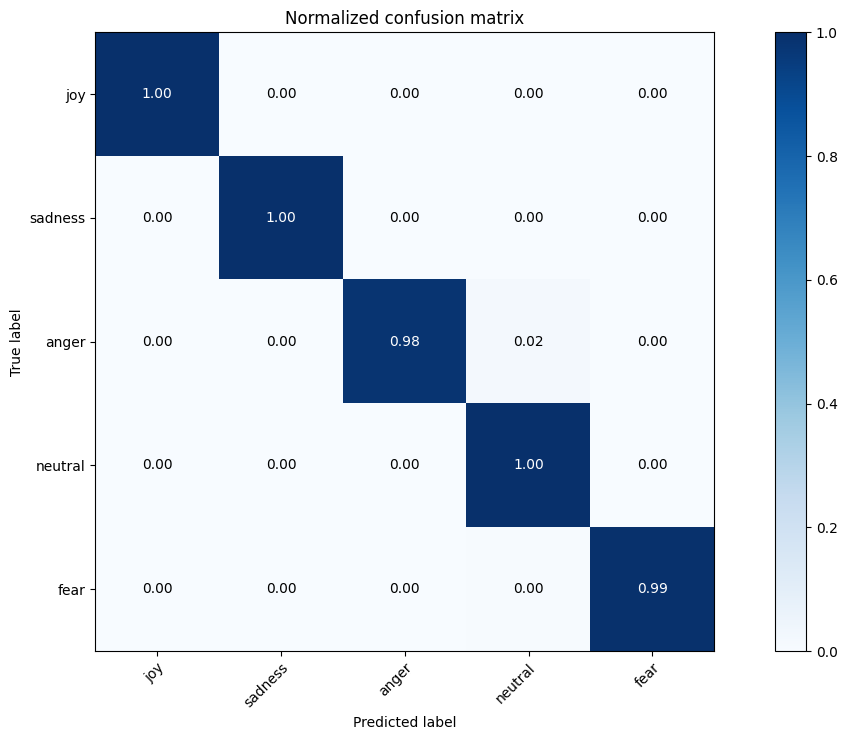

In [8]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [9]:
svm_model = Pipeline([
    ('tfidf', vect),
    ('rf', rf),
])

In [10]:
# save the model
filename = 'M:\\Third Year\\Projects\\SIH\\Codes\\nlp-text-emotion-master\\Final_Models\\tfidf_rf.sav'
pickle.dump(svm_model, open(filename, 'wb'))

###  Logistic Regression

Accuracy: 63.28%

F1 Score: 63.28

COnfusion Matrix:
 [[402 102  68  36  85]
 [ 94 421  74  13  77]
 [ 58  78 451  57  63]
 [ 42  41  59 467  29]
 [ 86  77  86  21 406]]


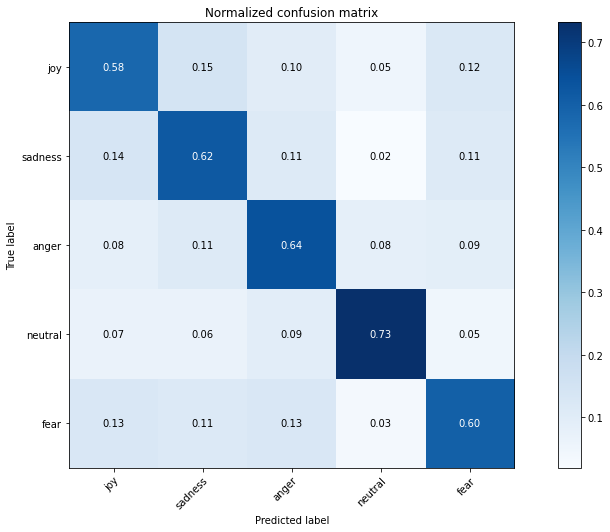

In [12]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

###  Linear Support Vector

Accuracy: 70.56%

F1 Score: 70.56

COnfusion Matrix:
 [[441  88  63  28  73]
 [ 63 497  55  10  54]
 [ 53  61 496  43  54]
 [ 27  28  51 505  27]
 [ 67  61  70  23 455]]


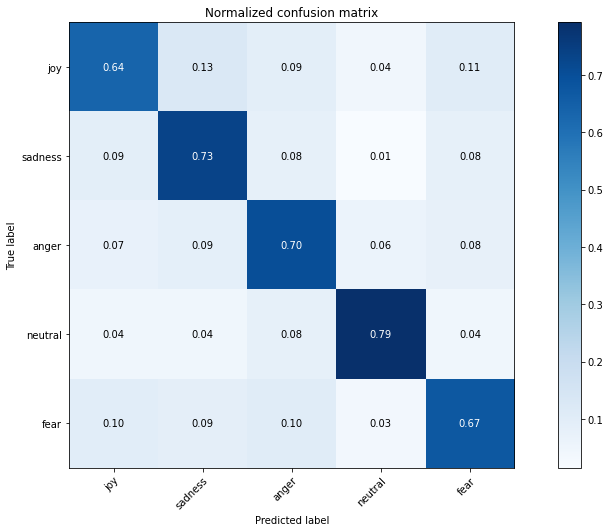

In [14]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## 4. Saving the tf-idf + SVM Model 


In [15]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [16]:
# save the model
filename = 'M:\\Third Year\\Projects\\SIH\\Codes\\nlp-text-emotion-master\\Final_Models\\tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [24]:
model = pickle.load(open(filename, 'rb'))
message = 'Glorified Trivialities: Karnataka HC Dismisses Criminal Cases of Cruelty Against Husband, Family'

print(type(message))
message = preprocess_and_tokenize(message)
model.predict([message])

<class 'str'>


array(['fear'], dtype=object)